# Домашнее задание 5. Линейные модели

In [34]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [135]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [130]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [149]:
# TODO check this code
train_users = df_users["uid"].values
#I changed here
ix = np.in1d(users, df_users_train["uid"])
X = X_dataset[np.where(ix)]

In [153]:
ix = np.in1d(df_users_train["uid"], users)
df_users_train_to_check = df_users_train[ix]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [155]:
Y = df_users_train_to_check['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (5944x18121) feature matrix, 5944 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

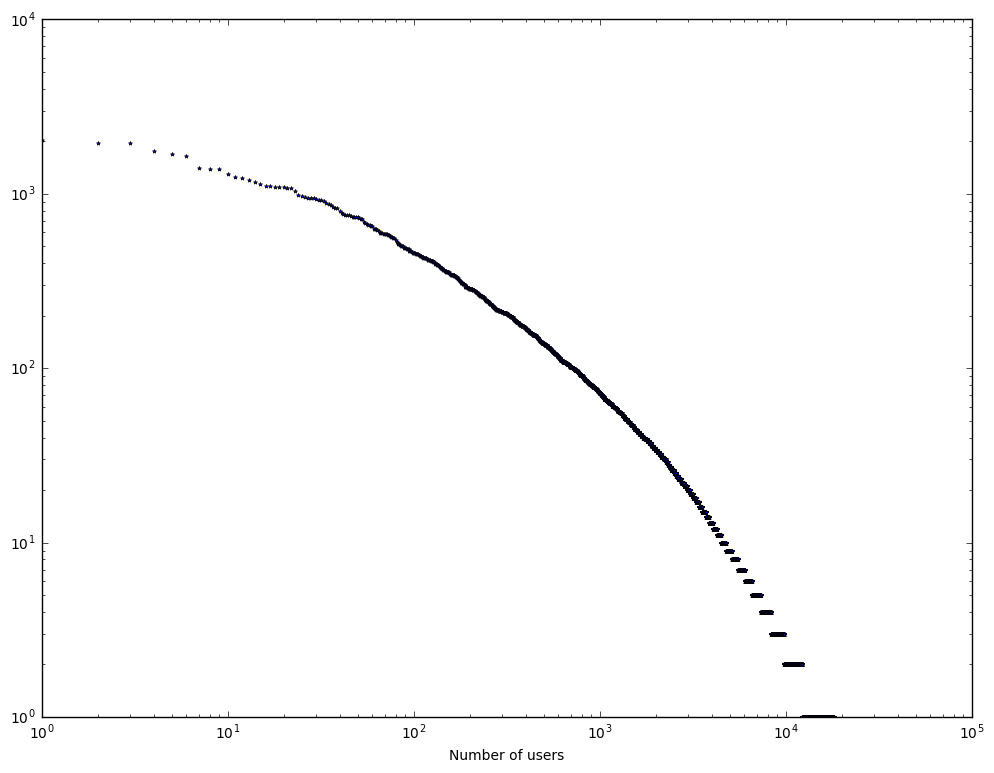

In [92]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    features_counts = x.getnnz(axis=0)
    res = np.sort(features_counts)
    res = res[::-1]
    x_val = np.arange(len(res))
    fig = plt.figure(figsize=(12, 9))
    plt.loglog(x_val, res, marker='*', linestyle='None', markersize=3)
    plt.xlabel("Number of users")
    plt.show()
    return features_counts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [156]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [94]:
USER_NAME = "i.markov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


In [95]:
# Sigmoid
def sigm(z):
    return np.clip(1.0 / (1 + exp(-z)), 0.000000000001, 0.999999999999)

# Quadratic difference 
def func_diff(w_pr, w_c):
    return np.dot(w_c - w_pr, w_c - w_pr)

Реализуем выбранный алгоритм

In [96]:
class LogisticRegression():
    
    def fit(self, X, Y=None):
        pr_w = np.zeros(len(X[1]) + 1)
        pr_w.fill(inf)
        self.ws = np.zeros(len(X[1]) + 1)
        self.ws[0] = log(np.mean(Y) / (1 - np.mean(Y)))
        # Add column of constants to X
        X = np.insert(X, 0, values=1, axis=1)
        # Current iterations count
        iters = 0
        diff = +inf
        
        while iters < self.max_iter and diff > self.eps:
            z = np.dot(X, self.ws)
            mu = sigm(z)
            w = mu * (1 - mu)
            s = z + (Y - mu) / w
            W = np.diag(w) 
            E = np.diag(np.ones(len(X[0])))
            E[0][0] = 0
            pr_w = self.ws
            # magic formula for newton's method for regression: (X.T*W*X + C*E)^-1 * X.T*W*s
            tmp = np.dot(np.dot(X.T, W), X)
            tmp += self.C * E
            tmp = np.linalg.inv(tmp)
            tmp = np.dot(np.dot(tmp, X.T), W)
            tmp = np.dot(tmp, s)
            # end of magic
            self.ws = tmp
            diff = func_diff(pr_w, self.ws)
            iters += 1
        return self
    
    def predict_proba(self, X):
        # Add column of constants to X
        X = np.insert(X, 0, values=1, axis=1)
        # Compute probabilities
        tmp = np.dot(X, self.ws)
        mu = sigm(tmp)
        return mu
    
    def __init__(self, C=1, eps=0.05, max_iter=20):
        # regularisation parameter 
        self.C = C
        self.eps = eps
        self.max_iter = max_iter

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [58]:
def distribution(pos, neg, step):
    
    # Compute number of both classes at each point
    distrib = np.zeros((1.0 / step + 1, 2))
    for i in neg:
        distrib[i / step][0] += 1
    for i in pos:
        distrib[i / step][1] += 1
    return distrib

def rates(distrib):
    # Compute TPR and FPR at each point
    tpr = np.zeros(len(distrib))
    fpr = np.zeros(len(distrib))
    sums = np.sum(distrib, axis=0)
    for i in xrange(len(distrib)):
        cur_sum = np.sum(distrib[i:], axis=0) #computing with current threshold
        tpr[i] = cur_sum[1] / sums[1] # normalization
        fpr[i] = cur_sum[0] / sums[0]
    return tpr, fpr

def area(tpr, fpr):
    # Compute area under curve defined by points
    # trapezoidal way of area computing
    area = 0
    for i in xrange(len(fpr) - 1):
        i1 = len(fpr) - i - 1
        i2 = len(fpr) - i - 2
        area += (fpr[i2] - fpr[i1]) * (tpr[i1] + tpr[i2]) / 2
    return area

def auroc(y_prob, y_true):
    # Compute area under ROC curve
    y_prob_round = np.around(y_prob, decimals=2)
    # Separate probabilities for positive and negative items
    pos = np.array([y_prob_round[i] for i in xrange(len(y_prob_round)) if y_true[i] == 1])
    neg = np.array([y_prob_round[i] for i in xrange(len(y_prob_round)) if y_true[i] == 0])
    # Compute number of both classes at each point
    distrib = distribution(pos, neg, 0.01)
    # Compute TPR and FPR at each point
    tpr, fpr = rates(distrib)
    # Compute area under curve defined by points
    return tpr, fpr, area(tpr, fpr)

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [157]:
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

def select_reg_parameter(C, X, Y):
    
    split = cv.KFold(len(X),shuffle=True, n_folds=5)
    auc = []
    for c in C:
        
        score_arr = np.zeros(5)
        fold = 0
        for train_index, test_index in split:
            logreg = LogisticRegression(c)
            logreg.fit(X=X[train_index],Y=Y[train_index])
            pred = logreg.predict_proba(X=X[test_index])
            _,_, score = auroc(pred, Y[test_index])
            score_arr[fold] = score
            fold+=1
        print 'c = %f ' % c + 'auroc = %f' % score_arr.mean()
        auc.append(score_arr.mean())
    return auc.index(max(auc))

index = select_reg_parameter(C, X1, Y)
print index

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


c = 0.001000 auroc = 0.509521
c = 0.010000 auroc = 0.509437
c = 0.100000 auroc = 0.509897
c = 1.000000 auroc = 0.511907
c = 10.000000 auroc = 0.516166
c = 100.000000 auroc = 0.512490
c = 1000.000000 auroc = 0.507290
c = 10000.000000 auroc = 0.494065
c = 100000.000000 auroc = 0.500000
4


In [158]:
C[index]

10

Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.519869


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


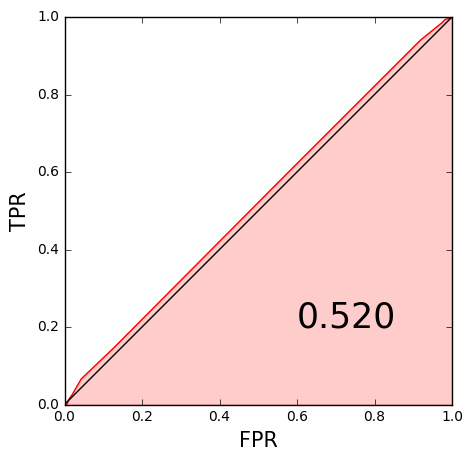

In [162]:
def classify(X, Y, test_size, C):
    x_train, x_test, y_train, y_test = cv.train_test_split(X1, Y, test_size=test_size)
    logreg = LogisticRegression(C=C, max_iter=15)
    logreg.fit(x_train, y_train)
    y_prob = logreg.predict_proba(x_test)
    return auroc(y_prob, y_test)

tpr, fpr, roc_auc = classify(X1, Y, 0.3, 1000)

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    fig = plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='red')
    plt.plot([0, 1], [0, 1], color='black')
    plt.fill_between(fpr, tpr, alpha=0.2, color='red')
    pl.text(0.6, 0.2, "%0.3f" % roc_auc, fontsize=25)
    plt.xlabel("FPR", fontsize=15)
    plt.ylabel("TPR", fontsize=15)
    plt.show()
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.